In [1]:
#load all libraries and packages
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# to explain visualization , features extraction choosing a particular audio file

In [2]:
#audio file wave form
from scipy.io import wavfile

data, sr = librosa.load('E:\\7th sem\\Natural Language Processing\\case study - speech emotion\\dataset\\speech-emotion-recognition-ravdess-data\\Actor_01\\03-01-01-01-01-01-01.wav')
print(type(data), type(sr))
print(data.shape)
print("sampling rate of this audio clip : ",sr)


<class 'numpy.ndarray'> <class 'int'>
(72839,)
sampling rate of this audio clip :  22050


Populating the interactive namespace from numpy and matplotlib


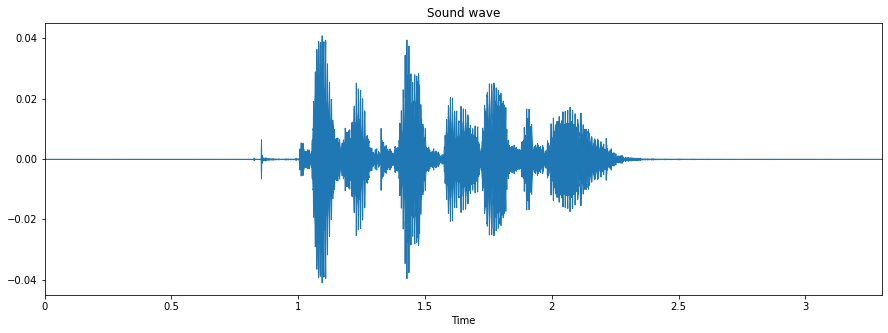

In [3]:
#audio file wave form
#to visualize sound kinda means to visualize airwaves.
%pylab inline
plt.figure(figsize=(15, 5))
plt.title('Sound wave');
librosa.display.waveplot(data, sr=sr)

Text(0, 0.5, 'Amplitude')

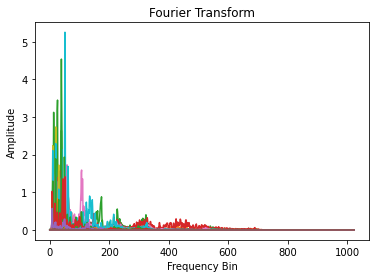

In [4]:
#Another mathematical representation of sound is the Fourier Transform. 
# Fourier Transform is a function that gets a signal in the time domain as input,
#and outputs its decomposition into frequencies.
n_fft = 2048
ft = np.abs(librosa.stft(data, hop_length = n_fft+1))
plt.plot(ft);
plt.title('Fourier Transform');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude')

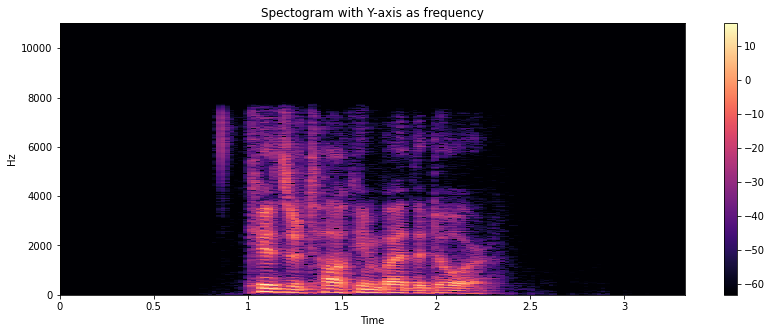

In [5]:
#Convert the audio waveform to spectrogram , y axis in terms of frequency
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
plt.title("Spectogram with Y-axis as frequency")
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar();

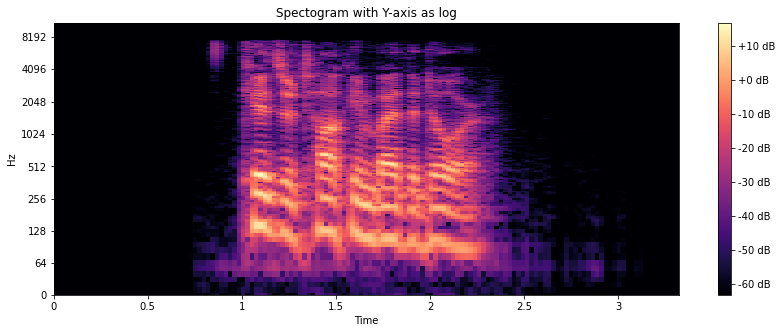

In [6]:
#Applying log transformation on the loaded audio signals   , y-axis in terms of log
plt.figure(figsize=(14, 5))
plt.title("Spectogram with Y-axis as log")
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB');

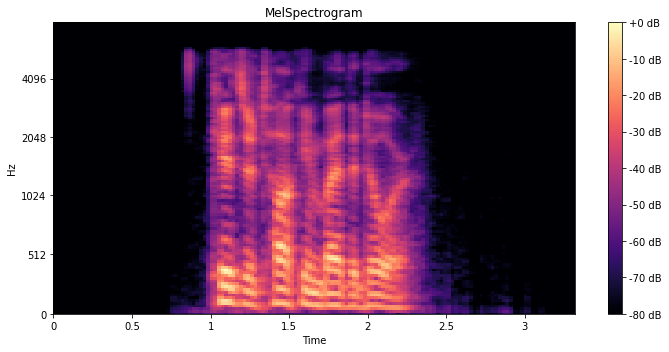

In [7]:
#mel spectogram   :    convert the frequency spectrogram to Mel scale to  get the MelSpectrogram. mel scale as its y - axis
melSpec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()

In [8]:
#feature extractions of audio file using librosa

stft = np.abs(librosa.stft(data))

# mfcc
mfcc_l = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T,axis=0)

# chroma
chroma_l = librosa.feature.chroma_stft(S=stft, sr=sr)
chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)

# mel
mel_l = librosa.feature.melspectrogram(data, sr=sr)
mel = np.mean(librosa.feature.melspectrogram(data, sr=sr).T,axis=0)


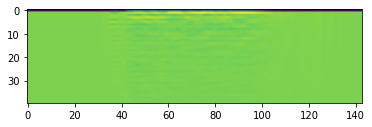

In [9]:
#plotting mfcc
plt.imshow(mfcc_l)

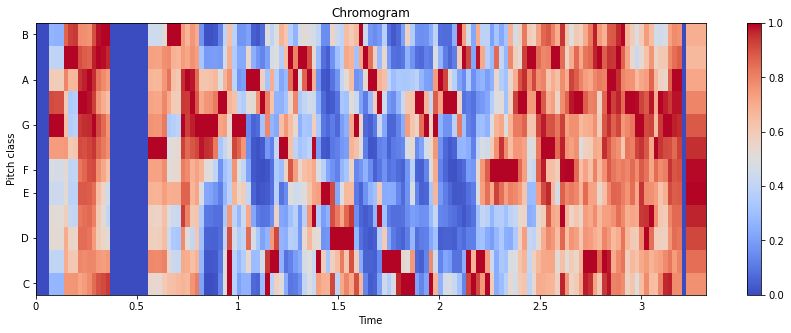

In [10]:
chromagram = librosa.feature.chroma_stft(data, sr=sr, hop_length=512)
plt.figure(figsize=(15, 5))
plt.title("Chromogram")
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')
plt.colorbar()

# implementation of speech emotion recognition using Ravdess dataset

In [11]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [12]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#emotions from RAVDESS dataset 

observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [13]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("E:\\7th sem\\Natural Language Processing\\case study - speech emotion\\dataset\\speech-emotion-recognition-ravdess-data\\Actor_*/*.wav"):
        file_name=os.path.basename(file) #load each audio file
        emotion=emotions[file_name.split("-")[2]] #extract the emotion from the name of the file
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True) #extract feature from the audio file
        x.append(feature) #array of 180 features extracted
        y.append(emotion) #the target variable
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [14]:
#loading data from the dataset and splitting data into train and test data

x_train,x_test,y_train,y_test=load_data(test_size=0.5) 

In [15]:
print((x_train.shape[0], x_test.shape[0])) #50 - 50 for training and testing data

(384, 384)


In [16]:
print(f'Features extracted: {x_train.shape[1]}') #total features extracted from training dataset

Features extracted: 180


In [17]:
df = pd.DataFrame(data=x_train[0:, 0:],index = [i for i in range(x_train.shape[0])],columns = ['f' + str(i) for i in range(x_train.shape[1])])

In [18]:
df["Emotion"]=y_train

# Data Preprocessing

In [19]:
df # training dataframe

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f171,f172,f173,f174,f175,f176,f177,f178,f179,Emotion
0,-535.934265,31.301857,-18.441574,1.829845,-7.744125,-14.450430,-15.056123,-11.019148,-3.572239,-2.173902,...,0.000750,0.000750,0.000390,0.000464,0.000405,0.000308,0.000190,0.000163,0.000065,disgust
1,-803.154297,31.410519,1.863715,6.359685,-3.843495,-4.061268,-13.583744,-8.369960,-6.830065,-4.008505,...,0.000008,0.000008,0.000008,0.000007,0.000011,0.000008,0.000004,0.000004,0.000003,calm
2,-594.502136,26.912891,-7.635659,0.430440,-16.659512,-5.810493,-26.663160,-5.384525,-9.386742,0.390651,...,0.000363,0.000285,0.000307,0.000296,0.000335,0.000142,0.000073,0.000058,0.000044,disgust
3,-666.348816,51.151867,-8.425525,4.857717,-9.331248,-9.429718,-11.773059,-0.748597,-3.133340,-3.288116,...,0.000052,0.000047,0.000063,0.000060,0.000035,0.000025,0.000022,0.000018,0.000006,disgust
4,-495.488922,39.839684,-4.183462,-2.009895,-4.544756,-6.817581,-21.288252,-10.571428,-8.247316,-5.686924,...,0.001261,0.001304,0.002384,0.002204,0.002532,0.002582,0.002489,0.001934,0.001243,disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,-617.609253,41.759995,-10.422521,3.815846,-8.885132,0.022940,-17.981617,-4.837789,-3.996083,-3.081832,...,0.000125,0.000113,0.000126,0.000148,0.000054,0.000032,0.000018,0.000008,0.000004,disgust
380,-383.007233,9.420696,-26.200876,2.628421,-17.898153,-16.619089,-16.220097,-11.781563,-1.197636,-13.881687,...,0.004942,0.004713,0.003613,0.003791,0.003923,0.003090,0.002704,0.001470,0.001169,fearful
381,-550.096558,17.029768,-11.457567,-12.360351,-13.201612,-14.330357,-17.293425,-12.690487,-5.314569,-7.820357,...,0.000448,0.000427,0.000390,0.000418,0.000249,0.000181,0.000152,0.000117,0.000085,disgust
382,-555.371033,47.137852,11.056081,14.558784,-0.142948,5.430053,-1.410167,-5.094169,-5.001351,7.682042,...,0.000334,0.000374,0.000547,0.000621,0.000495,0.000196,0.000161,0.000105,0.000065,disgust


In [20]:
df.shape #columns:180 features + 1 target variable,rows:384

(384, 181)

In [21]:
df.dtypes  #datatypes

f0         float64
f1         float64
f2         float64
f3         float64
f4         float64
            ...   
f176       float64
f177       float64
f178       float64
f179       float64
Emotion     object
Length: 181, dtype: object

In [22]:
df.isnull().sum()  #no null values

f0         0
f1         0
f2         0
f3         0
f4         0
          ..
f176       0
f177       0
f178       0
f179       0
Emotion    0
Length: 181, dtype: int64

In [23]:
df.describe().transpose() #5 point summary of the features

,count,mean,std,min,25%,50%,75%,max
f0,384.0,-574.326702,98.484852,-8.039968e+02,-642.413208,-579.441986,-510.969261,-303.718872
f1,384.0,42.072831,16.699023,-6.449682e+00,32.875922,43.155321,54.301226,92.224472
f2,384.0,-7.893569,13.587765,-5.318034e+01,-16.648026,-7.155434,1.340887,27.351612
f3,384.0,8.839132,8.952359,-1.648250e+01,2.549136,7.964680,15.601161,32.878681
f4,384.0,-5.401642,8.665997,-2.908041e+01,-11.051095,-5.221185,0.815965,16.200363
...,...,...,...,...,...,...,...,...
f175,384.0,0.000828,0.001860,6.176705e-07,0.000045,0.000200,0.000751,0.019879
f176,384.0,0.000714,0.001700,4.267749e-07,0.000035,0.000160,0.000593,0.018788
f177,384.0,0.000522,0.001239,2.161050e-07,0.000025,0.000116,0.000449,0.014850
f178,384.0,0.000360,0.000905,1.587881e-07,0.000014,0.000085,0.000290,0.011959


# MLP Model classifier

In [24]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=800)

In [25]:
model.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=800, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [26]:
y_pred=model.predict(x_test)

In [27]:
y_pred #predicted values

array(['happy', 'fearful', 'happy', 'happy', 'fearful', 'calm', 'happy',
       'disgust', 'calm', 'disgust', 'happy', 'fearful', 'happy', 'happy',
       'disgust', 'happy', 'calm', 'disgust', 'disgust', 'disgust',
       'calm', 'disgust', 'disgust', 'calm', 'fearful', 'happy',
       'disgust', 'disgust', 'fearful', 'fearful', 'happy', 'disgust',
       'happy', 'fearful', 'happy', 'calm', 'calm', 'fearful', 'calm',
       'calm', 'happy', 'calm', 'calm', 'calm', 'fearful', 'calm',
       'disgust', 'happy', 'calm', 'happy', 'fearful', 'fearful',
       'fearful', 'fearful', 'happy', 'fearful', 'disgust', 'happy',
       'calm', 'calm', 'disgust', 'calm', 'happy', 'calm', 'happy',
       'calm', 'calm', 'disgust', 'fearful', 'happy', 'fearful',
       'fearful', 'fearful', 'fearful', 'fearful', 'disgust', 'fearful',
       'happy', 'fearful', 'fearful', 'disgust', 'calm', 'fearful',
       'calm', 'disgust', 'calm', 'disgust', 'fearful', 'disgust',
       'fearful', 'disgust', 'disg

In [28]:
np.unique(y_pred) #unique values predicted

array(['calm', 'disgust', 'fearful', 'happy'], dtype='<U7')

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred) #confusion matrix

array([[93,  7,  6,  1],
       [ 9, 69, 11,  7],
       [ 2,  4, 63, 14],
       [ 5,  9, 19, 65]], dtype=int64)

In [30]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100)) 

Accuracy: 75.52%


#    NOVELTY OF WORK || || test our model by giving ur voice as input   

In [31]:
#install these to run below code
pip install wave
pip isntall pyaudio

SyntaxError: invalid syntax (<ipython-input-31-b312db139d6d>, line 1)

In [45]:
import pyaudio
import wave                                           #records ur voice

CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "output10.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


In [46]:
#audio file wave form
from scipy.io import wavfile

data, sr = librosa.load('output10.wav')
print(type(data), type(sr))
print(data.shape)
print("sampling rate of this audio clip : ",sr)


<class 'numpy.ndarray'> <class 'int'>
(88064,)
sampling rate of this audio clip :  22050


Populating the interactive namespace from numpy and matplotlib


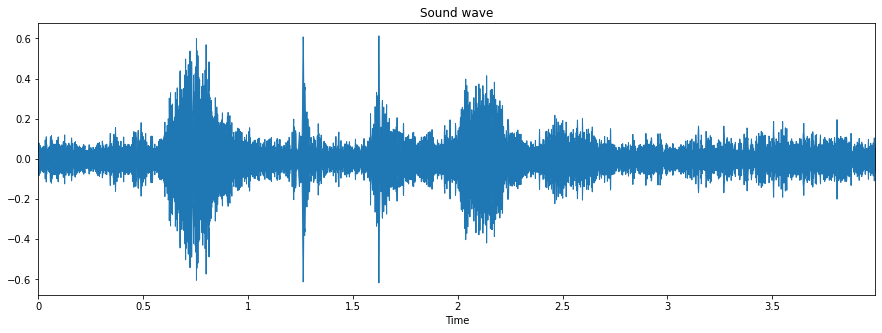

In [47]:
#audio file wave form
#to visualize sound kinda means to visualize airwaves.
%pylab inline
plt.figure(figsize=(15, 5))
plt.title('Sound wave');
librosa.display.waveplot(data, sr=sr)

In [48]:
def ex(file_name, mfcc, chroma, mel):
        X ,sample_rate = librosa.load('output10.wav')
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        return result

In [49]:
feature=ex(data, mfcc=True, chroma=True, mel=True) #extract feature from the audio file

In [51]:
x=[]
x.append(feature)
pred=model.predict(x)
print("Your emotion is ", pred[0])                # your emotion 

Your emotion is  happy
